## Problem Statement


#### Build a Neural network-based classifier using some of the customer features that can determine whether the customer will leave or not in the next 6 months
** Bank wants to focus on customers who will be leaving and also more concern about improving false negatives ( which  predicts that customer will stay but actually will leave the bank)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import recall_score,f1_score,accuracy_score

import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras import optimizers

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization



## 1. Data Loading and  Statistic Summary

In [2]:
df=pd.read_csv("bank.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Shape and Data type

In [3]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} in dataset')

There are 10000 rows and 14 in dataset


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


* It seems that there is no null value and data types are also correct for columns. We can later change categorical columns to categorical type.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


* There are some 0 values for tenure and Balance column which means there are few customers which are totally new to the bank and some have null balance. We can further check if all of customer with null balance are new customers to bank.
* Minimum age of customer is 18.
* there are some outliers in Balance.
* Age, Credit score , balance and estimatedSalary seem to have some skewness.

In [6]:
df[["CreditScore","Age","Tenure","Balance","NumOfProducts","EstimatedSalary"]].skew()

CreditScore       -0.071607
Age                1.011320
Tenure             0.010991
Balance           -0.141109
NumOfProducts      0.745568
EstimatedSalary    0.002085
dtype: float64

* Age and numOfPRoduct are highly positively skewed.
* balance also has significant negative skewness.

In [7]:
cat_col = ["NumOfProducts","HasCrCard","IsActiveMember","Exited","Geography","Gender"]
for col in cat_col:
    value_counts = df[col].value_counts()
    print(value_counts)
    print("\n")


1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64


1    7055
0    2945
Name: HasCrCard, dtype: int64


1    5151
0    4849
Name: IsActiveMember, dtype: int64


0    7963
1    2037
Name: Exited, dtype: int64


France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64


Male      5457
Female    4543
Name: Gender, dtype: int64




* There are more male customer than female.
* Half of the customers are from FRance.
* Only 20% cusotomers left and it's imbalanced dataset.
* ALmost 70% customers  have credit cards.
* Most of the customers has 1-2 products.

#### Null check

In [8]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

* There is no null values.

#### Dropping Ids

* As RowNumber and CustomerId are unique values for each customer and surname is also unique to customer and will not impact Exited field so we can easily drop them.

In [9]:
df.drop(columns=["RowNumber","CustomerId","Surname"],axis=1,inplace=True)

#### Verifying duplicates

In [10]:
df[df.duplicated()==True].sum()

CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

* There is no duplicates which is good.

#### `HasCrCard`,`IsActiveMember` ,`NumberOfProducts`and `Exited` are columns with only binary values and can be converted to categorical type easily.

In [11]:
col_cat=["HasCrCard","IsActiveMember","Exited",'NumOfProducts']
for col in col_cat:
    df[col]=df[col].astype("category")

## 2. Exploratory Data Analysis

### Univariant Plot

In [12]:
def histogram_boxPlot(data,feature,figsize=(12,7),kde=False,bins=None):
    f2,(ax_hist,ax_box)= plt.subplots(nrows=2,sharex=True,figsize=figsize)
    
    sns.boxplot(
        data=data, x=feature, ax=ax_box, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist
    )
    ax_hist.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

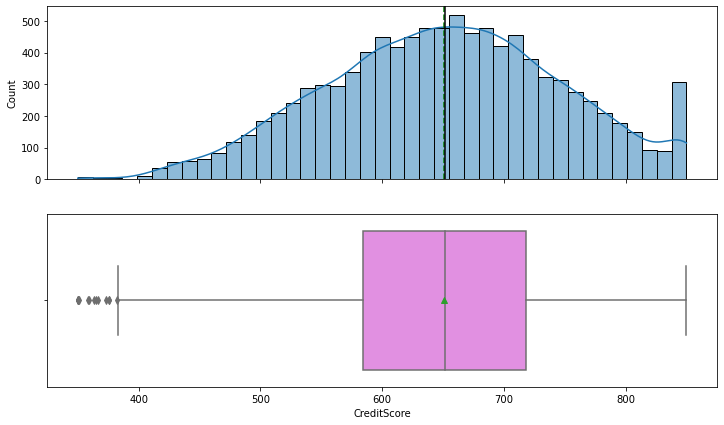

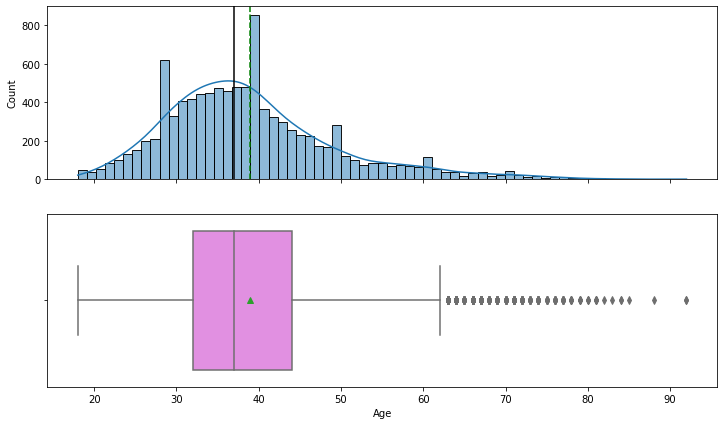

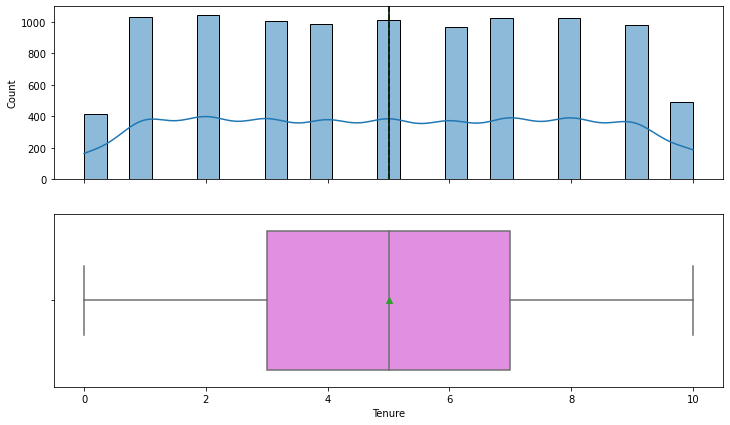

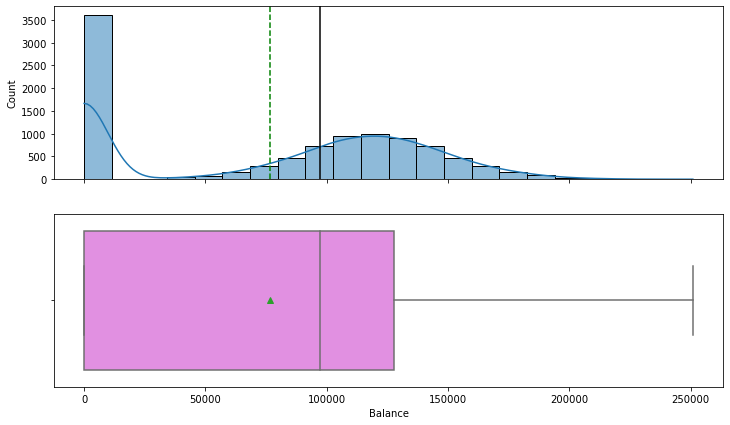

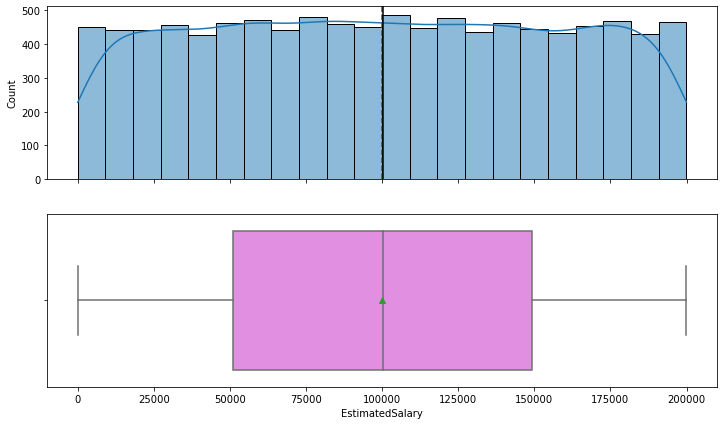

In [13]:
col_num=df.select_dtypes(include='number').columns.to_list()
for col in col_num:
    histogram_boxPlot(df,col,kde=True)

* `CreditScore`and `Age` have outliers which needs to be handled.
*  Distribution for balance and age is highly skewed.

In [14]:
# function to create labeled barplots


def labeled_barplot(data, feature, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(data=data, x=feature,  palette="Paired",order=data[feature].value_counts().index[:n].sort_values(),)

    for p in ax.patches:
        label = "{:.1f}%".format(100 * p.get_height() / total)  
        
        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(label,(x, y),ha="center", va="center",size=12,xytext=(0, 5),textcoords="offset points",)  # annotate the percentage

    plt.show()  # show the plot

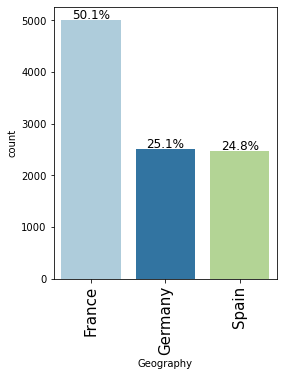

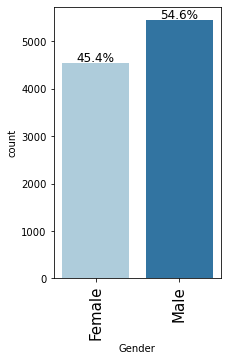

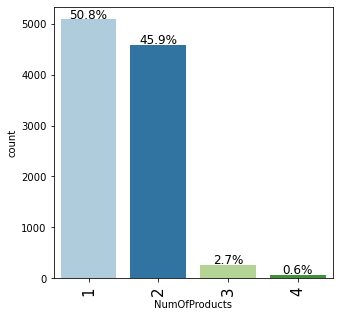

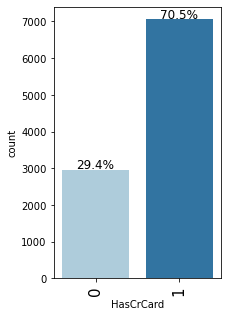

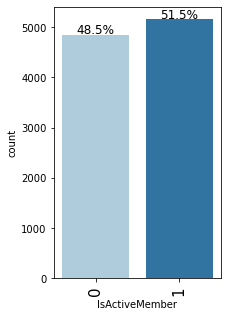

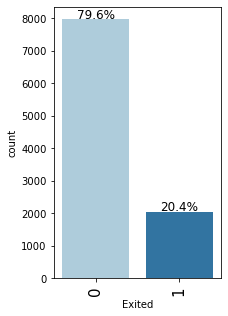

In [15]:
cat_col = df.select_dtypes(exclude='number')
#cat_col = ["HasCrCard","IsActiveMember","Exited",'NumOfProducts',"Geography","Gender"]
for col in cat_col:
   labeled_barplot(df,col) 

* Only 20% customers only exited after 6 months.This is unbalanced dataset.
* There is no difference between active and inactive customer counts.
* Almost 70% customers have credit cards.
* 50% customers are located in France.  

#### Pairplot

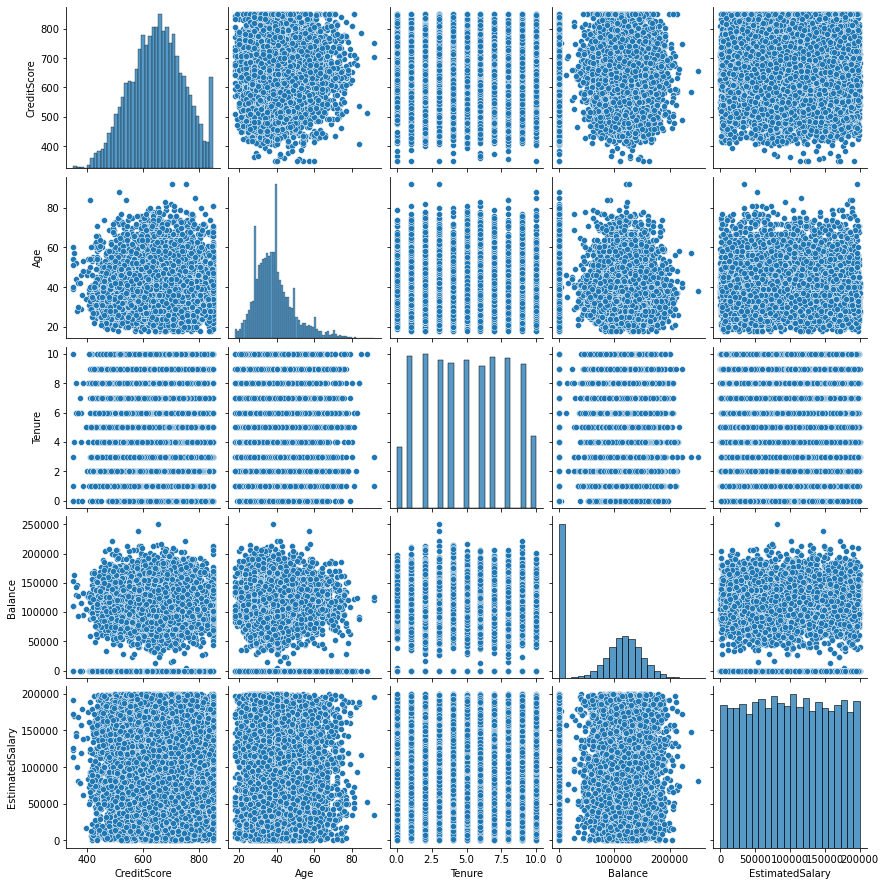

In [16]:
df_num = df.select_dtypes(include='number')
sns.pairplot(data=df_num)

* There is no pattern between `CreditScore`,`Age`,`Tenure`,`Balance`,`EstimatedSalary`. It seems that this dataset is non-linear.

<ipython-input-17-a2e8ec432480>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num["Exited"]=df["Exited"]


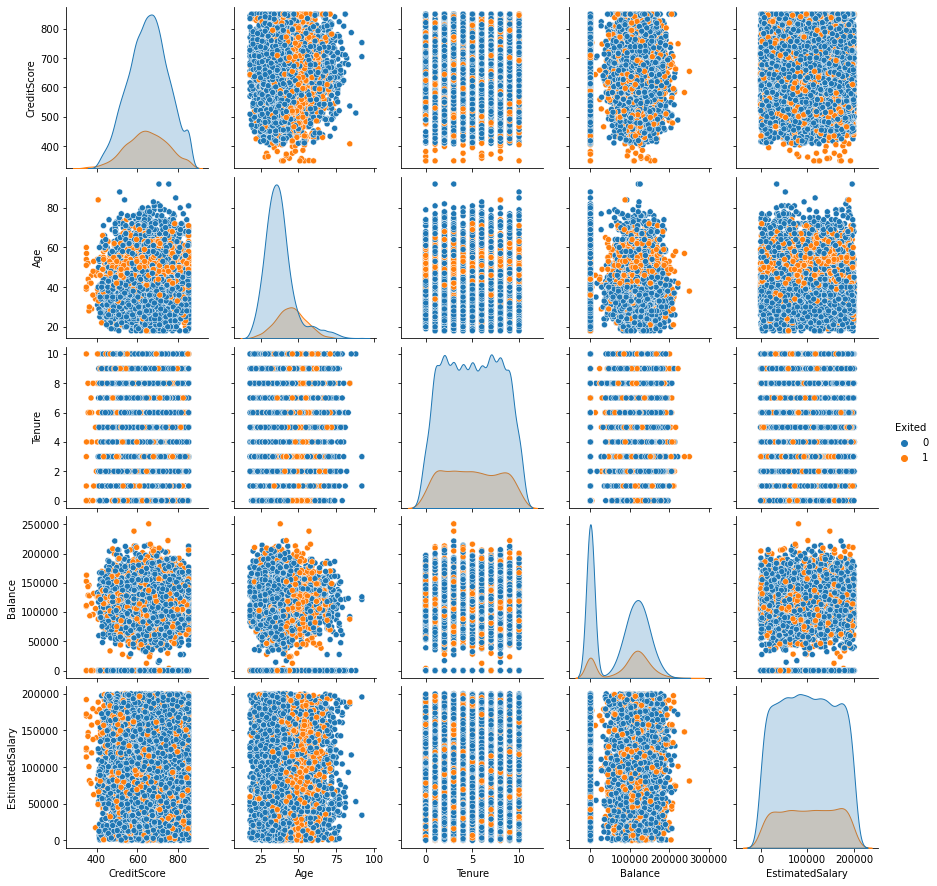

In [17]:
df_num = df.select_dtypes(include='number')
df_num["Exited"]=df["Exited"]
sns.pairplot(data=df_num,hue="Exited" )

* there seems no pattern for Exited and not exited customers.

In [18]:
df_num.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Exited'], dtype='object')

#### Heatmap

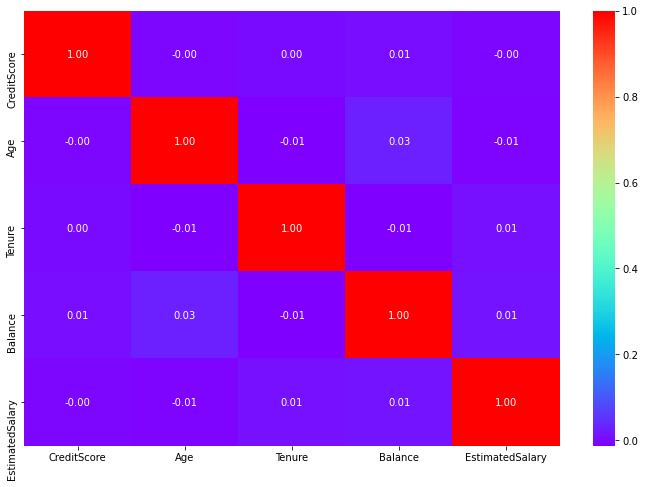

In [19]:
plt.figure(figsize=(12,8))
sns.heatmap(df_num.corr(),annot=True,fmt='.2f',cmap='rainbow', )
plt.show()

* There is no co-relation between these variables and are independent.

### Bivariant -plot

### BarPlot

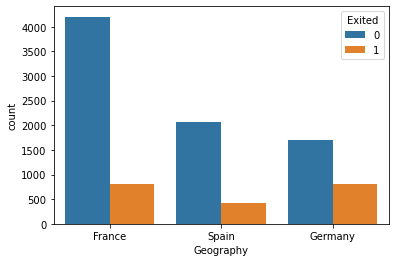

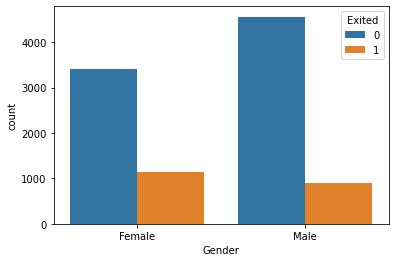

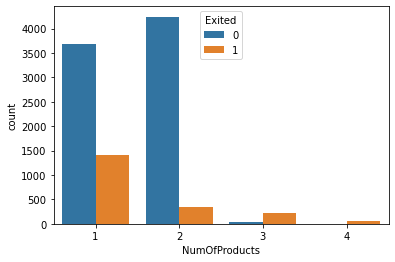

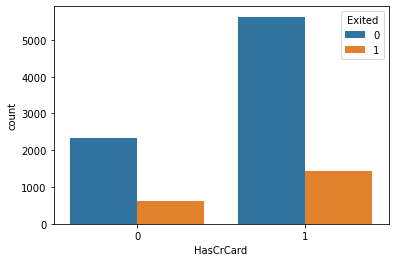

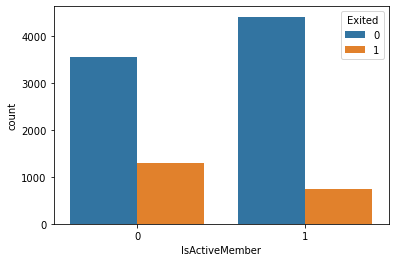

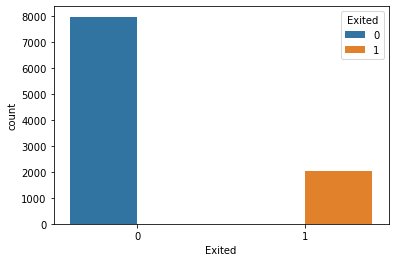

In [20]:
cat_col = df.select_dtypes(exclude='number')
for col in cat_col:
   sns.countplot(data=df,x=col,hue="Exited")
   plt.show()



<AxesSubplot:xlabel='Tenure', ylabel='Balance'>

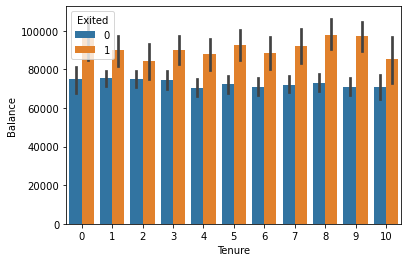

In [21]:
sns.barplot(data=df, x="Tenure", y="Balance", hue="Exited")

<AxesSubplot:xlabel='Tenure', ylabel='Balance'>

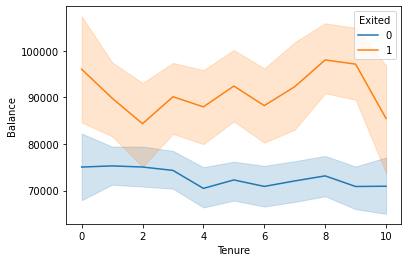

In [22]:
sns.lineplot(data=df, x="Tenure", y="Balance", hue="Exited")

<AxesSubplot:xlabel='Age', ylabel='EstimatedSalary'>

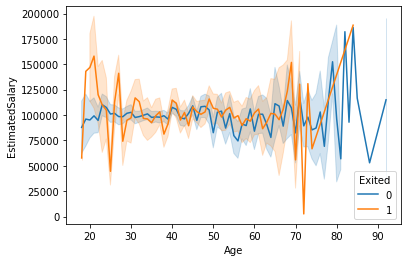

In [23]:
#Estimated  salary ,age and exited

sns.lineplot(data=df, x="Age", y="EstimatedSalary", hue="Exited")


* There is no clear pattern between estimatedsalary and Age for customer who exited or not exited.Let's check EstinatedSalary and Balance.


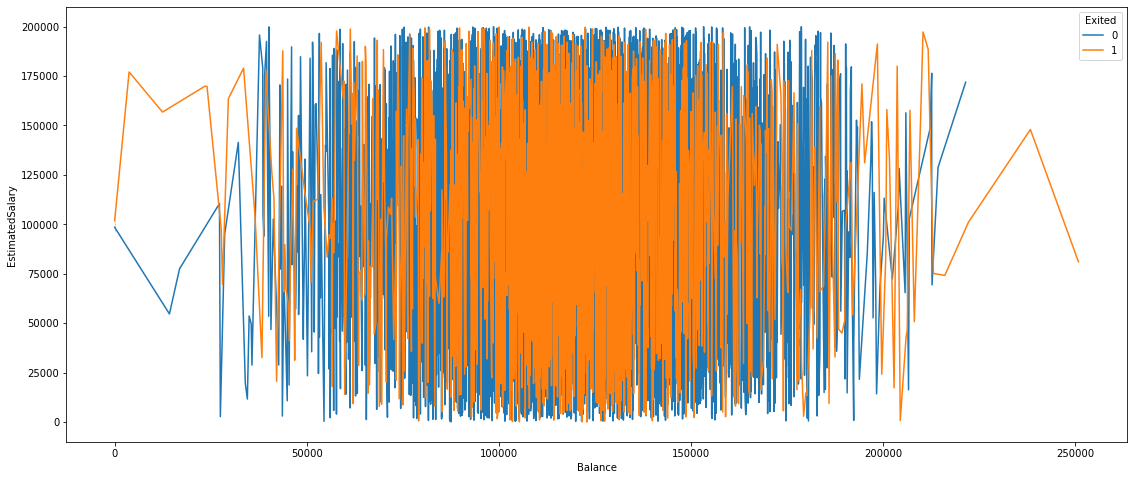

In [24]:
#Estimated  salary ,balance and exited
plt.figure(figsize=(19,8))
sns.lineplot(data=df, x="Balance", y="EstimatedSalary", hue="Exited")
plt.show()



* There is no defined pattern for estimated salary.

<AxesSubplot:xlabel='Age', ylabel='Balance'>

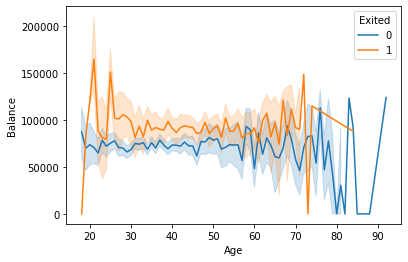

In [25]:
sns.lineplot(data=df, x="Age", y="Balance", hue="Exited")


* Balance for customers with age between 18-72 yrs and who exited is almost higher than customer who did not exited.


<Figure size 2160x1440 with 0 Axes>

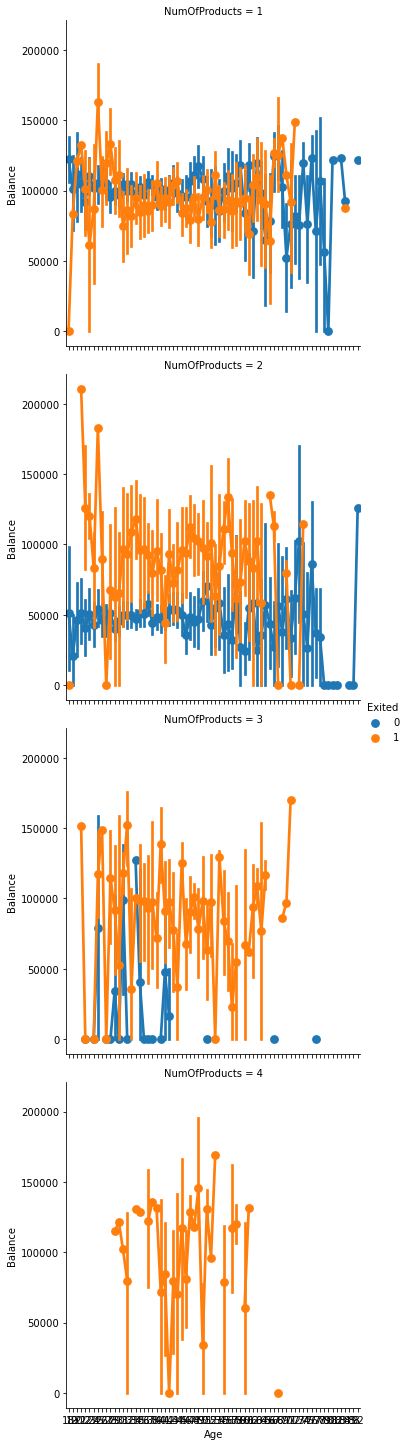

In [26]:
#balance, number of product, age, exited
plt.figure(figsize=(30,20))
sns.catplot(y="Balance",x="Age",row="NumOfProducts",data=df,hue="Exited",kind='point');
plt.show()


* All of the customers with number of product 4 have exited in 6 minths.
* Most of the customer with number of product 3 have existed in 6 months.


<Figure size 2160x1440 with 0 Axes>

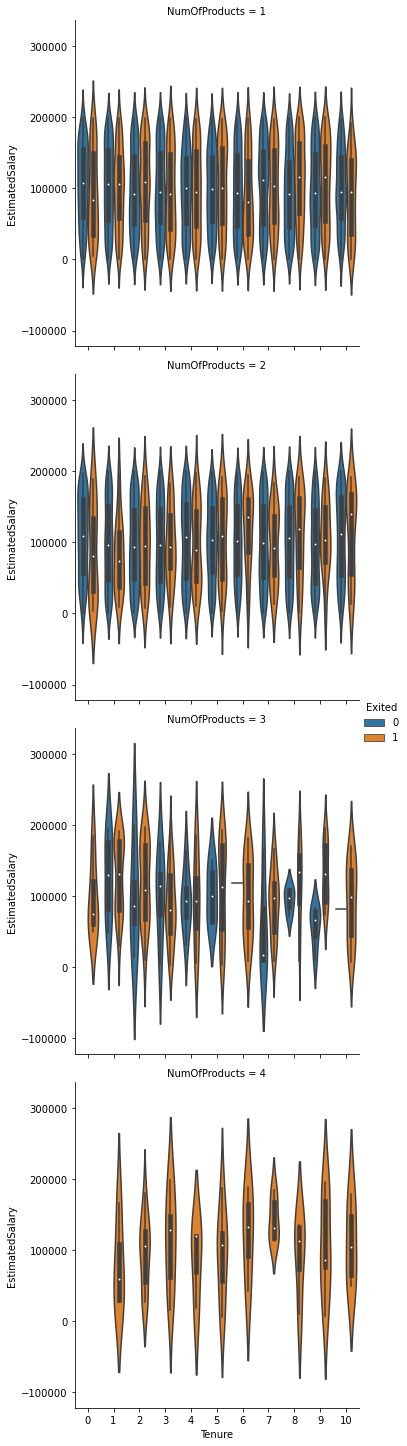

In [27]:
#estimatedSalary, number of product, tenure, exited
plt.figure(figsize=(30,20))
sns.catplot(y="EstimatedSalary",x="Tenure",row="NumOfProducts",data=df,hue="Exited",kind='violin');
plt.show()

* All of the cutomers with 4 product has been exited.
* all of the customers with 3 products and tenure 0,6 and 10 has been exited.

<AxesSubplot:xlabel='HasCrCard', ylabel='CreditScore'>

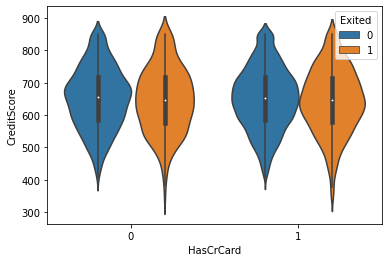

In [28]:
#credit score , hascreditcard, exted
sns.violinplot(data=df,x="HasCrCard",y="CreditScore",hue="Exited")

* There is no pattern between creditScore and hasCrCard column for exited and non Exited customer.

<Figure size 2160x1440 with 0 Axes>

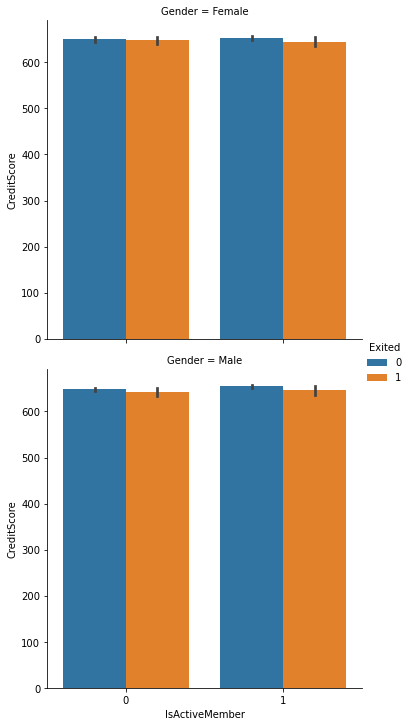

In [29]:
# gender,credit score, is active member and exited


#balance, number of product, age, exited
plt.figure(figsize=(30,20))
sns.catplot(y="CreditScore",x="IsActiveMember",row="Gender",data=df,hue="Exited",kind='bar');
plt.show()

* There is no difference for credit score for different gender and customers who exited or not.

<Figure size 2160x1440 with 0 Axes>

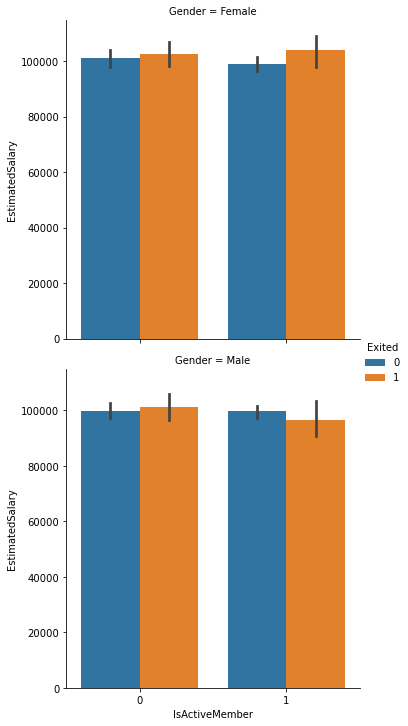

In [30]:

#balance, number of product, age, exited
plt.figure(figsize=(30,20))
sns.catplot(y="EstimatedSalary",x="IsActiveMember",row="Gender",data=df,hue="Exited",kind='bar');
plt.show()

* There is no difference for Estimated Salary for different gender and customers who exited or not.

## 3. Key insights from Data exploration

* Only 20% customers only exited after 6 months.This is unbalanced dataset.
* It seems that this dataset is non-linear.
* There is no difference between active and inactive customer counts.
* Almost 70% customers have credit cards.
* 50% customers are located in France.
* Balance is higher for customers who exited in 6 months and Balance for customers with age between 18-72 yrs and who exited is almost higher than customer who did not exited.
* All of the customers with number of product 4 have exited in 6 minths and more than 50% customers with number of product 3 have existed in 6 months.
* All of the cutomers with 4 product and customers with 3 products and tenure 0,6 and 10 has been exited regardless of estimated salary.


## 4. Data Preprocessing

### Missing value

In [31]:
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

* there is no missing values.

### OulierTreatment

* There were some outlier in column Age and CreditScore

In [32]:
def treat_outliers(data,col):
    '''
    treats outliers in a varaible
    col: str, name of the numerical varaible
    data: data frame
    col: name of the column
    '''
    Q1=data[col].quantile(0.25) # 25th quantile
    Q3=data[col].quantile(0.75)  # 75th quantile
    IQR=Q3-Q1
    Lower_Whisker = Q1 - 1.5*IQR 
    Upper_Whisker = Q3 + 1.5*IQR
    data[col] = np.clip(data[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker 
                                                            # and all the values above upper_whishker will be assigned value of upper_Whisker 
    return data

In [33]:
col_outliers=["Age","CreditScore"]
for col in col_outliers:
    df = treat_outliers(df,col);


In [34]:
#Method to verify if outliers are treated.
def plot_box(df,col):
    ## verifying if all outliers are treated
    sns.boxplot(data=df,x=col);
    
    plt.title(col)          
    plt.show()

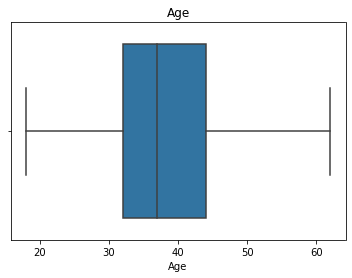

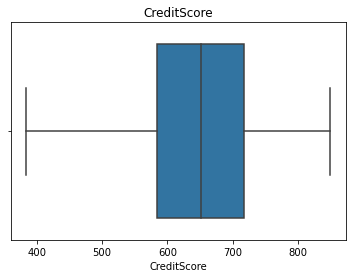

In [35]:
#verify outliers
for col in col_outliers:
    plot_box(df,col)


* all of the outliers are already treated now.

### Scaling of different features

In [36]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [37]:
df.select_dtypes(include="category").columns

Index(['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited'], dtype='object')

In [38]:
df.dtypes

CreditScore           int64
Geography            object
Gender               object
Age                   int64
Tenure                int64
Balance             float64
NumOfProducts      category
HasCrCard          category
IsActiveMember     category
EstimatedSalary     float64
Exited             category
dtype: object

In [39]:
df_scaled = df.copy()


In [40]:
#converting data type of numOFProducts for scaling
df_scaled['NumOfProducts'] = df_scaled['NumOfProducts'].astype('int64')

In [41]:
cols = df_scaled.select_dtypes(include="number").columns.to_list()
cols

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [42]:

scalar = StandardScaler()

for col in cols:
    df_scaled[col] =  scalar.fit_transform(df_scaled[col].values.reshape(-1,1))
    df_scaled.drop(col,axis=1)


In [43]:
df_scaled.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,-0.326878,France,Female,0.342615,-1.041760,-1.225848,-0.911583,1,1,0.021886,1
1,-0.440804,Spain,Female,0.240011,-1.387538,0.117350,-0.911583,0,1,0.216534,0
2,-1.538636,France,Female,0.342615,1.032908,1.333053,2.527057,1,0,0.240687,1
3,0.501675,France,Female,0.034803,-1.387538,-1.225848,0.807737,0,0,-0.108918,0
4,2.065569,Spain,Female,0.445219,-1.041760,0.785728,-0.911583,1,1,-0.365276,0


### Creating dummy for non-numeric columns

In [44]:
col_dummies = ["Geography","Gender"]
df_scaled=pd.get_dummies(data=df_scaled,columns=col_dummies,drop_first=True)
df_scaled.head()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326878,0.342615,-1.041760,-1.225848,-0.911583,1,1,0.021886,1,0,0,0
1,-0.440804,0.240011,-1.387538,0.117350,-0.911583,0,1,0.216534,0,0,1,0
2,-1.538636,0.342615,1.032908,1.333053,2.527057,1,0,0.240687,1,0,0,0
3,0.501675,0.034803,-1.387538,-1.225848,0.807737,0,0,-0.108918,0,0,0,0
4,2.065569,0.445219,-1.041760,0.785728,-0.911583,1,1,-0.365276,0,0,1,0


### Splitting data

In [45]:
X=df_scaled.drop(columns=['Exited'],axis=1)
y=df_scaled['Exited']

In [46]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

In [47]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 11)
(2000, 11)
(8000,)
(2000,)


## 5. Model Building

#### Creating Model 1: Basic ANN Model

In [48]:
#initializing ANN

# Initialize the constructor
model = Sequential()

#model=Sequential()

#first dese layer with input shape
input_layer=Dense(16,activation='relu',input_shape=X_train.shape )
model.add(input_layer)
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [49]:
## Model compilation
##creating optimizer with default learning rate
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy','Recall','Precision'])


In [50]:
#Lets  print summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8000, 16)          192       
_________________________________________________________________
dense_1 (Dense)              (None, 8000, 32)          544       
_________________________________________________________________
dense_2 (Dense)              (None, 8000, 1)           33        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


#### Training the model

In [51]:
history=model.fit(X_train,y_train,batch_size=15,epochs=20,validation_split=0.2)

Epoch 1/20
427/427 [==============================] - 4s 5ms/step - loss: 0.4799 - accuracy: 0.7800 - recall: 0.1452 - precision: 0.3845 - val_loss: 0.4218 - val_accuracy: 0.8169 - val_recall: 0.1970 - val_precision: 0.7333
Epoch 2/20
427/427 [==============================] - 1s 3ms/step - loss: 0.4005 - accuracy: 0.8272 - recall: 0.2942 - precision: 0.6649 - val_loss: 0.3928 - val_accuracy: 0.8288 - val_recall: 0.3045 - val_precision: 0.7133
Epoch 3/20
427/427 [==============================] - 1s 3ms/step - loss: 0.3787 - accuracy: 0.8411 - recall: 0.3784 - precision: 0.6980 - val_loss: 0.3728 - val_accuracy: 0.8456 - val_recall: 0.3791 - val_precision: 0.7651
Epoch 4/20
427/427 [==============================] - 1s 3ms/step - loss: 0.3618 - accuracy: 0.8486 - recall: 0.4139 - precision: 0.7185 - val_loss: 0.3600 - val_accuracy: 0.8544 - val_recall: 0.4299 - val_precision: 0.7742
Epoch 5/20
427/427 [==============================] - 1s 3ms/step - loss: 0.3529 - accuracy: 0.8539 - re

#### plotting train and test loss

In [52]:
hist=pd.DataFrame(history.history)
hist['epochs']=history.epoch
#hist

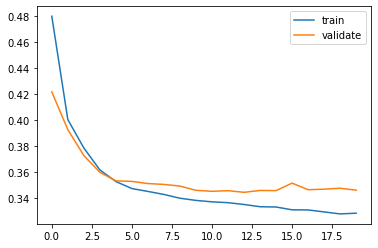

In [53]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train","validate"), loc=1)

* From the above plot, we can see that there is a big difference between train loss and  validation loss. So we need better mode or tunning this model.

#### Evaluation

In [54]:
score1 = model.evaluate(X_test,y_test)


63/63 [==============================] - 0s 1ms/step - loss: 0.3476 - accuracy: 0.8615 - recall: 0.4545 - precision: 0.7708


* It seems that model has good accuracy of .855 but we have to see for further improvements and tunning as this is imbalance dataset.

In [55]:
print(score1)

[0.34764981269836426, 0.8615000247955322, 0.4545454680919647, 0.7708333134651184]


In [56]:
y_test.value_counts()

0    1593
1     407
Name: Exited, dtype: int64

*                     0=No ( Customer did not leave the bank )
*                    1=Yes ( Customer left the bank )



## 6. Model Performance evaluation and improvements

### 6.1 Improtant metrics

* As bank needs to identify which customer will exit in next 6 months and needs to focus to make them stay, "Recall" is most important metrics in this. As we want to mimimize false negavites and improve on true positives.

### 6.2 Model evaluation

#### Identifying optiomal threshold using ROC-AUC curves

In [57]:
def make_confusion_matrix(y_pred, y_test,labels=[1,0]):
    
    
    cm=metrics.confusion_matrix(y_test,y_pred,labels=[1,0])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - Exited - Bank","Actual - Not Exited"]],
                  columns = [i for i in ['Predicted - Exited -Bank','Predicted - Not Exited - Bank']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### ROC curve on training dataset

In [58]:
def roc_curve_plot(model,x,y):
    y_pred=model.predict(x)
    logit_roc_auc_train = roc_auc_score(y,y_pred)
    fpr, tpr, thresholds = roc_curve(y,y_pred)
    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_train)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()


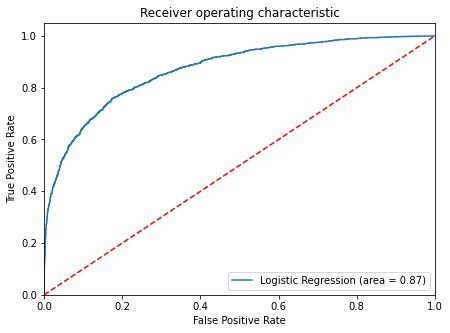

In [59]:

y_pred_train=model.predict(X_train)
logit_roc_auc_train = roc_auc_score(y_train,y_pred_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### ROC curve on test data

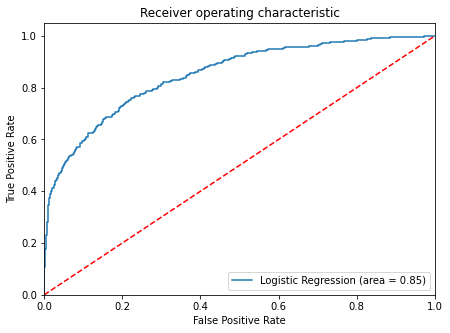

In [60]:

y_pred1=model.predict(X_test)
logit_roc_auc_train = roc_auc_score(y_test,y_pred1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### optimal threashold using ROC curve

In [61]:
def get_optimal_threshold(y,y_pred):
    # Optimal threshold as per AUC-ROC curve
    # The optimal cut off would be where tpr is high and fpr is low
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print(optimal_threshold)
    return optimal_threshold

In [62]:
def create_classLabels(y_pred,y,optimal_threshold):
    
    for i in range(len(y)):
        if y_pred[i]>optimal_threshold:
            y_pred[i]=1
        else:
            y_pred[i]=0
    

In [63]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred1)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

0.18662941


In [64]:
## predict y and convert probabilities to binary value
y_pred = model.predict(X_test)

for i in range(len(y_test)):
    if y_pred[i]>optimal_threshold:
        y_pred[i]=1
    else:
        y_pred[i]=0

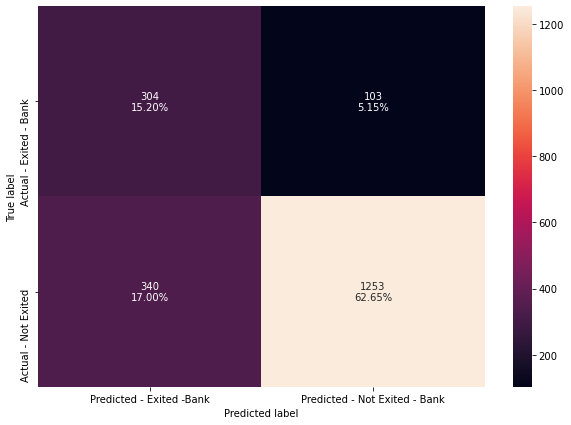

In [65]:
make_confusion_matrix(y_pred,y_test)

* model predict 77.8% TP and TN and only 22.2% FP and FN.

#### threshold using precision-recall plot

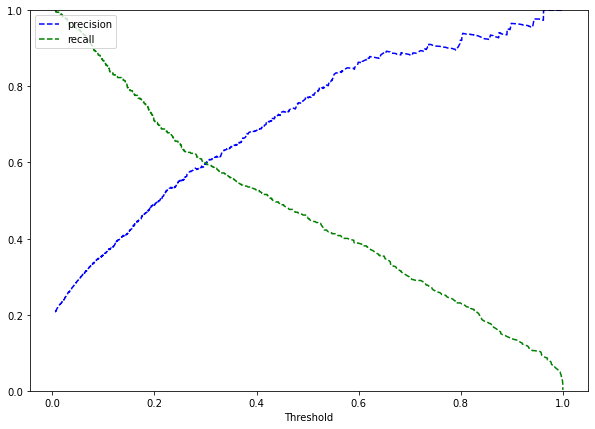

In [66]:

prec, rec, tre = precision_recall_curve(y_test, y_pred1,)

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
plt.figure(figsize=(10,7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

* threshold from precision recall curve is almost .35.

In [67]:
## predict y and convert probabilities to binary value
opt_threshold_prep = 0.35
y_pred1 = model.predict(X_test)

for i in range(len(y_test)):
    if y_pred1[i]>opt_threshold_prep:
        y_pred1[i]=1
    else:
        y_pred1[i]=0

In [68]:
## predict y and convert probabilities to binary value
opt_threshold_prep = 0.35
y_pred1_train = model.predict(X_train)

for i in range(len(y_train)):
    if y_pred1_train[i]>opt_threshold_prep:
        y_pred1_train[i]=1
    else:
        y_pred1_train[i]=0

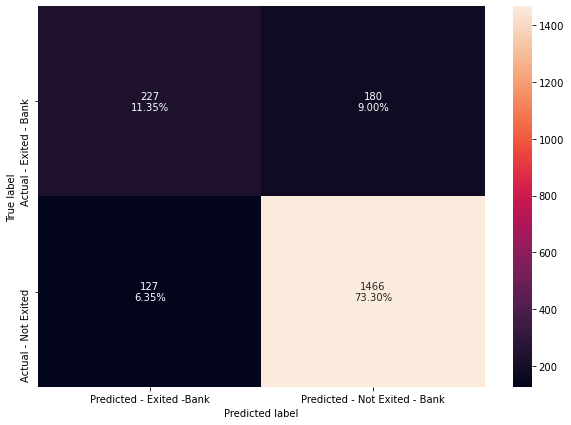

In [69]:
make_confusion_matrix(y_pred1,y_test)

* As finding optimal threshold is better than optimal threshold from ROC-AUC curve. today accuracy is almost 83.55% and recall and precision is also almost 60%. We can do improve it by tunning ANN.

In [70]:
recall_test_1 = recall_score(y_test,y_pred1)
print(f'Recall score for test data - model1 - {recall_test_1}')

f1score_test_1 = f1_score(y_test,y_pred1)
print(f'f1 score for test data - model1 - {f1score_test_1}')

acc_score_test_1 = accuracy_score(y_test,y_pred1)
print(f'accuracy score for test data - model1 - {acc_score_test_1}')

recall_train_1 = recall_score(y_train,y_pred1_train)
print(f'Recall score for train data - model1 - {recall_train_1}')

f1score_train_1 = f1_score(y_train,y_pred1_train)
print(f'f1 score for train data - model1 - {f1score_train_1}')

acc_score_train_1 = accuracy_score(y_train,y_pred1_train)
print(f'accuracy score for train data - model1 - {acc_score_train_1}')

Recall score for test data - model1 - 0.5577395577395577
f1 score for test data - model1 - 0.5965834428383706
accuracy score for test data - model1 - 0.8465
Recall score for train data - model1 - 0.6073619631901841
f1 score for train data - model1 - 0.6336
accuracy score for train data - model1 - 0.856875


### 6.3 Model perfomance improvement

#### Model 2 

* LEt's creat a model with non-defaultRMSprop optimizer

In [71]:
#initializing ANN

model2=Sequential()

#first dese layer with input shape
input_layer=Dense(16,activation='relu',input_shape=X_train.shape )
model2.add(input_layer)
model2.add(Dense(32,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))

In [72]:
## Model compilation
##creating optimizer with default learning rate

optimizer = tf.keras.optimizers.Adam(0.01)
model2.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy','Recall'])

In [73]:
#Lets  print summary of model
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8000, 16)          192       
_________________________________________________________________
dense_4 (Dense)              (None, 8000, 32)          544       
_________________________________________________________________
dense_5 (Dense)              (None, 8000, 1)           33        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


#### Training the model

In [74]:
history2=model2.fit(X_train,y_train,batch_size=15,epochs=30,validation_split=0.2)

Epoch 1/30
427/427 [==============================] - 3s 4ms/step - loss: 0.4025 - accuracy: 0.8281 - recall: 0.3290 - val_loss: 0.3536 - val_accuracy: 0.8537 - val_recall: 0.5104
Epoch 2/30
427/427 [==============================] - 1s 3ms/step - loss: 0.3577 - accuracy: 0.8492 - recall: 0.4386 - val_loss: 0.3507 - val_accuracy: 0.8581 - val_recall: 0.4418
Epoch 3/30
427/427 [==============================] - 1s 3ms/step - loss: 0.3515 - accuracy: 0.8564 - recall: 0.4525 - val_loss: 0.3683 - val_accuracy: 0.8544 - val_recall: 0.5672
Epoch 4/30
427/427 [==============================] - 1s 3ms/step - loss: 0.3468 - accuracy: 0.8575 - recall: 0.4587 - val_loss: 0.3648 - val_accuracy: 0.8487 - val_recall: 0.4328
Epoch 5/30
427/427 [==============================] - 1s 3ms/step - loss: 0.3462 - accuracy: 0.8569 - recall: 0.4633 - val_loss: 0.3444 - val_accuracy: 0.8537 - val_recall: 0.4925
Epoch 6/30
427/427 [==============================] - 1s 3ms/step - loss: 0.3395 - accuracy: 0.8611 

#### plotting train and test loss

In [75]:
hist2=pd.DataFrame(history2.history)
hist2['epochs']=history2.epoch
#hist

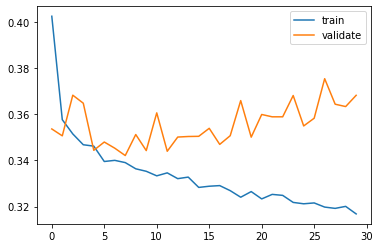

In [76]:
plt.plot(hist2['loss'])
plt.plot(hist2['val_loss'])
plt.legend(("train","validate"), loc=1)

* From the above plot, we can see that there is a big difference between train loss and  validation loss. So we need better mode or tunning this model.

#### Evaluation

In [77]:
score2 = model2.evaluate(X_test,y_test)


63/63 [==============================] - 0s 1ms/step - loss: 0.3858 - accuracy: 0.8485 - recall: 0.4914


* It seems that model has good accuracy of .855 but we have to see for further improvements and tunning as this is imbalance dataset.

In [78]:
print(score2)

[0.38575246930122375, 0.8485000133514404, 0.49140048027038574]


In [79]:
y_pred2=model2.predict(X_test)

In [80]:
y_pred2_train=model2.predict(X_train)

#### roc curve

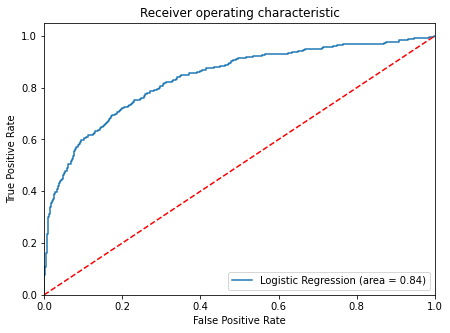

In [81]:
roc_curve_plot(model2,X_test,y_test)

In [82]:
#get optimal threshold
opt_Threshold2= get_optimal_threshold(y_test,y_pred2)

0.20591924


In [83]:
create_classLabels(y_pred2,y_test,opt_Threshold2)

In [84]:
create_classLabels(y_pred2_train,y_train,opt_Threshold2)

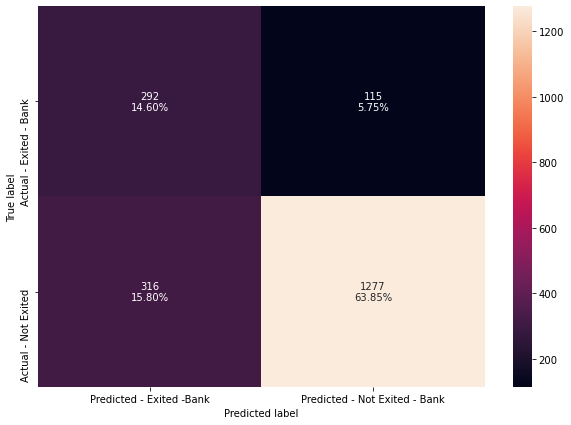

In [85]:
make_confusion_matrix(y_pred2,y_test)

* model predict 77.8% TP and TN and only 22.2% FP and FN.

#### threshold using precision-recall plot

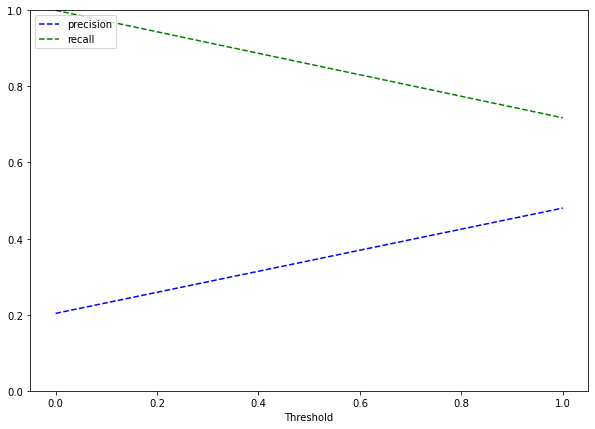

In [86]:

prec, rec, tre = precision_recall_curve(y_test, y_pred2,)

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
plt.figure(figsize=(10,7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

* there isn o common point for precision and recall.

In [87]:



recall_test_2 = recall_score(y_test,y_pred2)
print(f'Recall score for testing data - model2 - {recall_test_2}')

f1score_test_2 = f1_score(y_test,y_pred2)
print(f'f1 score for testing data -model2 - {f1score_test_2}')

acc_score_test_2 = accuracy_score(y_test,y_pred2)
print(f'accuracy score for testing data -model2 - {acc_score_test_2}')

recall_train_2 = recall_score(y_train,y_pred2_train)
print(f'Recall score for train data - model2 - {recall_train_2}')

f1score_train_2 = f1_score(y_train,y_pred2_train)
print(f'f1 score for train data - model2 - {f1score_train_2}')

acc_score_train_2 = accuracy_score(y_train,y_pred2_train)
print(f'accuracy score for train data - model2 - {acc_score_train_2}')

Recall score for testing data - model2 - 0.7174447174447175
f1 score for testing data -model2 - 0.5753694581280788
accuracy score for testing data -model2 - 0.7845
Recall score for train data - model2 - 0.7705521472392638
f1 score for train data - model2 - 0.6253422952452078
accuracy score for train data - model2 - 0.811875


#### Model 3 - with RMSprop optimizer with 1 hidden layer

In [88]:
#initializing ANN

model3=Sequential()

#first dese layer with input shape
input_layer=Dense(16,activation='relu',input_shape=X_train.shape )
model3.add(input_layer)
model3.add(Dense(32,activation='relu'))
model3.add(Dense(1,activation='sigmoid'))

In [89]:
## Model compilation
##creating optimizer with default learning rate
optimizer = tf.keras.optimizers.RMSprop(0.001)
model3.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy','Recall'])

In [90]:
#Lets  print summary of model
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8000, 16)          192       
_________________________________________________________________
dense_7 (Dense)              (None, 8000, 32)          544       
_________________________________________________________________
dense_8 (Dense)              (None, 8000, 1)           33        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


#### Training the model

In [91]:
history3=model3.fit(X_train,y_train,batch_size=15,epochs=30,validation_split=0.2)

Epoch 1/30
427/427 [==============================] - 3s 4ms/step - loss: 0.4678 - accuracy: 0.7991 - recall: 0.1097 - val_loss: 0.4300 - val_accuracy: 0.8144 - val_recall: 0.1582
Epoch 2/30
427/427 [==============================] - 1s 3ms/step - loss: 0.4019 - accuracy: 0.8253 - recall: 0.3012 - val_loss: 0.3900 - val_accuracy: 0.8394 - val_recall: 0.3045
Epoch 3/30
427/427 [==============================] - 1s 3ms/step - loss: 0.3745 - accuracy: 0.8398 - recall: 0.3645 - val_loss: 0.3677 - val_accuracy: 0.8469 - val_recall: 0.4269
Epoch 4/30
427/427 [==============================] - 1s 3ms/step - loss: 0.3621 - accuracy: 0.8469 - recall: 0.4178 - val_loss: 0.3593 - val_accuracy: 0.8494 - val_recall: 0.4806
Epoch 5/30
427/427 [==============================] - 2s 4ms/step - loss: 0.3550 - accuracy: 0.8497 - recall: 0.4394 - val_loss: 0.3731 - val_accuracy: 0.8462 - val_recall: 0.3194
Epoch 6/30
427/427 [==============================] - 1s 3ms/step - loss: 0.3526 - accuracy: 0.8520 

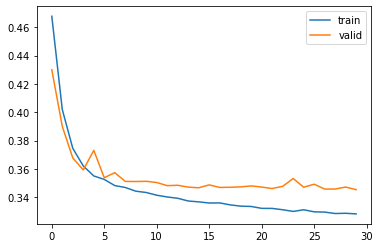

In [92]:
# Capturing learning history per epoch
hist3  = pd.DataFrame(history3.history)
hist3['epoch'] = history3.epoch

# Plotting accuracy at different epochs
plt.plot(hist3['loss'])
plt.plot(hist3['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#### plot confusion matrix after identifying optimal threshold

#### Evaluation

In [93]:
score3 = model3.evaluate(X_test,y_test)


63/63 [==============================] - 0s 2ms/step - loss: 0.3541 - accuracy: 0.8585 - recall: 0.4717


* It seems that model has good accuracy of .851 but we have to see for further improvements and tunning as this is imbalance dataset.

In [94]:
print(score3)

[0.35413405299186707, 0.8585000038146973, 0.47174447774887085]


In [95]:
y_pred3=model3.predict(X_test)

In [96]:
y_pred3_train=model3.predict(X_train)

#### roc curve

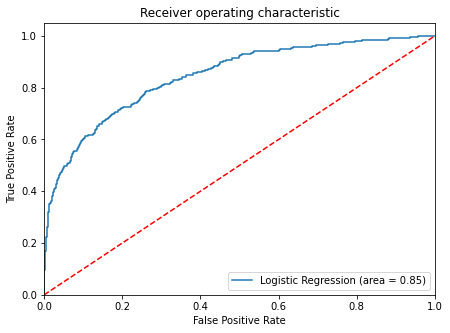

In [97]:
roc_curve_plot(model3,X_test,y_test)

In [98]:
#get optimal threshold
opt_Threshold3= get_optimal_threshold(y_test,y_pred3)

0.15324542


In [99]:
create_classLabels(y_pred3,y_test,opt_Threshold3)

In [100]:
create_classLabels(y_pred3_train,y_train,opt_Threshold3)

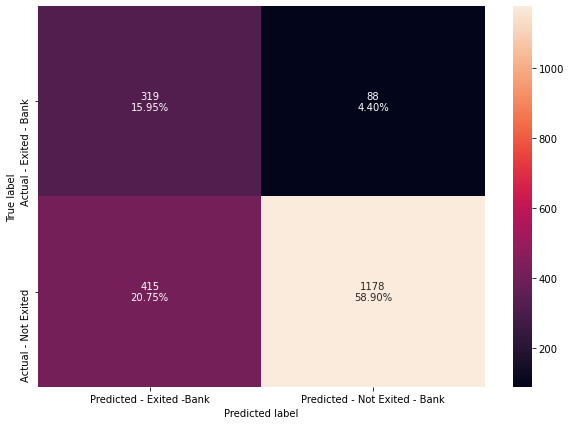

In [101]:
make_confusion_matrix(y_pred3,y_test)

* As finding optimal threshold is better than optimal threshold from ROC-AUC curve. today accuracy is almost 83.55% and recall and precision is also almost 60%. We can do improve it by tunning ANN.

In [102]:



recall_3 = recall_score(y_test,y_pred3)
print(f'Recall score for model3 - {recall_3}')

f1score_3 = f1_score(y_test,y_pred3)
print(f'f1 score for model13- {f1score_3}')

acc_score_3 = accuracy_score(y_test,y_pred3)
print(f'accuracy score for model3 - {acc_score_3}')

recall_train_3 = recall_score(y_train,y_pred3_train)
print(f'Recall score for train data - model3 - {recall_train_3}')

f1score_train_3 = f1_score(y_train,y_pred3_train)
print(f'f1 score for train data - model3 - {f1score_train_3}')

acc_score_train_3 = accuracy_score(y_train,y_pred3_train)
print(f'accuracy score for train data - model3 - {acc_score_train_3}')

Recall score for model3 - 0.7837837837837838
f1 score for model13- 0.5591586327782647
accuracy score for model3 - 0.7485
Recall score for train data - model3 - 0.8177914110429448
f1 score for train data - model3 - 0.5874834728955487
accuracy score for train data - model3 - 0.766


#### Model 4 - with RMSprop optimizer and 2 hidden layers

In [103]:
#initializing ANN

model4=Sequential()

#first dese layer with input shape
input_layer=Dense(16,activation='relu',input_shape=X_train.shape )
model4.add(input_layer)
model4.add(Dense(32,activation='relu'))
model4.add(Dense(64,activation='relu'))

model4.add(Dense(1,activation='sigmoid'))

In [104]:
## Model compilation
##creating optimizer with default learning rate
optimizer = tf.keras.optimizers.RMSprop(0.001)
#optimizer = keras.optimizers.RMSprop(0.001)  # Defining the optimizer 
model4.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy','Recall'])

In [105]:
#Lets  print summary of model
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 8000, 16)          192       
_________________________________________________________________
dense_10 (Dense)             (None, 8000, 32)          544       
_________________________________________________________________
dense_11 (Dense)             (None, 8000, 64)          2112      
_________________________________________________________________
dense_12 (Dense)             (None, 8000, 1)           65        
Total params: 2,913
Trainable params: 2,913
Non-trainable params: 0
_________________________________________________________________


#### Training the model

In [106]:
history4=model4.fit(X_train,y_train,batch_size=15,epochs=40,validation_split=0.2)

Epoch 1/40
427/427 [==============================] - 4s 4ms/step - loss: 0.4419 - accuracy: 0.8095 - recall: 0.1575 - val_loss: 0.4107 - val_accuracy: 0.8225 - val_recall: 0.2537
Epoch 2/40
427/427 [==============================] - 1s 3ms/step - loss: 0.3953 - accuracy: 0.8316 - recall: 0.3444 - val_loss: 0.3820 - val_accuracy: 0.8500 - val_recall: 0.3701
Epoch 3/40
427/427 [==============================] - 1s 3ms/step - loss: 0.3691 - accuracy: 0.8439 - recall: 0.4147 - val_loss: 0.3634 - val_accuracy: 0.8487 - val_recall: 0.4746
Epoch 4/40
427/427 [==============================] - 1s 3ms/step - loss: 0.3571 - accuracy: 0.8536 - recall: 0.4463 - val_loss: 0.3558 - val_accuracy: 0.8575 - val_recall: 0.4716
Epoch 5/40
427/427 [==============================] - 1s 3ms/step - loss: 0.3528 - accuracy: 0.8525 - recall: 0.4463 - val_loss: 0.3536 - val_accuracy: 0.8575 - val_recall: 0.4627
Epoch 6/40
427/427 [==============================] - 1s 3ms/step - loss: 0.3487 - accuracy: 0.8527 

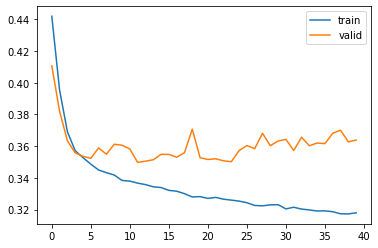

In [107]:
# Capturing learning history per epoch
hist4  = pd.DataFrame(history4.history)
hist4['epoch'] = history4.epoch

# Plotting accuracy at different epochs
plt.plot(hist4['loss'])
plt.plot(hist4['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#### plot confusion matrix after identifying optimal threshold

#### Evaluation

In [108]:
score4 = model4.evaluate(X_test,y_test)


63/63 [==============================] - 0s 2ms/step - loss: 0.3637 - accuracy: 0.8585 - recall: 0.4693


* It seems that model has good accuracy of .851 but we have to see for further improvements and tunning as this is imbalance dataset.

In [109]:
print(score4)

[0.36374837160110474, 0.8585000038146973, 0.4692874550819397]


In [110]:
y_pred4=model4.predict(X_test)

In [111]:
y_pred4_train=model4.predict(X_train)

#### roc curve

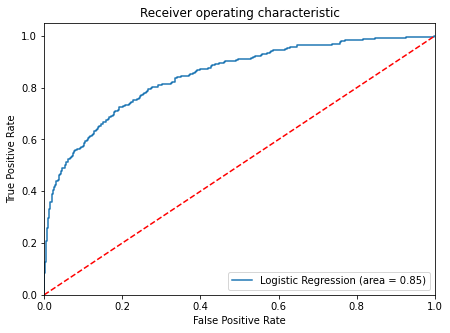

In [112]:
roc_curve_plot(model4,X_test,y_test)

In [113]:
#get optimal threshold
opt_Threshold4= get_optimal_threshold(y_test,y_pred4)

0.1989494


In [114]:
create_classLabels(y_pred4,y_test,opt_Threshold4)

In [115]:
create_classLabels(y_pred4_train,y_train,opt_Threshold4)

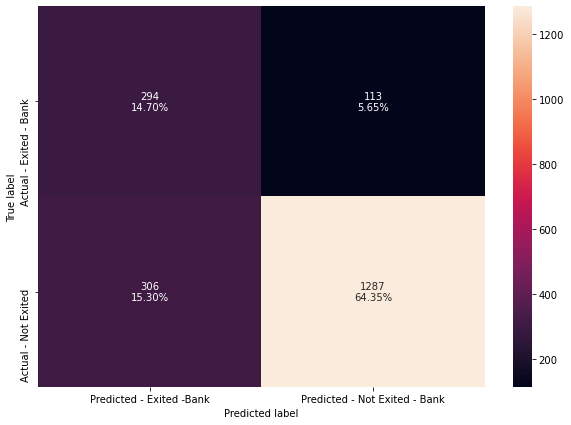

In [116]:
make_confusion_matrix(y_pred4,y_test)

* model predict 74.2% TP and TN and only 25.8% FP and FN.

In [117]:



recall_4 = recall_score(y_test,y_pred4)
print(f'Recall score for model4 - {recall_4}')

f1score_4 = f1_score(y_test,y_pred4)
print(f'f1 score for model4 - {f1score_4}')

acc_score_4 = accuracy_score(y_test,y_pred4)
print(f'accuracy score for model4 - {acc_score_4}')


recall_train_4 = recall_score(y_train,y_pred4_train)
print(f'Recall score for train data - model4 - {recall_train_4}')

f1score_train_4 = f1_score(y_train,y_pred4_train)
print(f'f1 score for train data - model4 - {f1score_train_4}')

acc_score_train_4 = accuracy_score(y_train,y_pred4_train)
print(f'accuracy score for train data - model4 - {acc_score_train_4}')

Recall score for model4 - 0.7223587223587223
f1 score for model4 - 0.5839126117179743
accuracy score for model4 - 0.7905
Recall score for train data - model4 - 0.7711656441717791
f1 score for train data - model4 - 0.6286571642910729
accuracy score for train data - model4 - 0.814375


#### Model 5 - eary stopping

In [118]:
#adding earlystopping callback
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=15, 
                             verbose=0, mode='min', restore_best_weights= True)
#initializing ANN
model5=Sequential()
input_layer=Dense(16,activation='relu',input_shape=X_train.shape )
model5.add(input_layer)
model5.add(Dense(32,activation='relu'))
model5.add(Dense(64,activation='relu'))

model5.add(Dense(1,activation='sigmoid'))

## Model compilation
##creating optimizer with default learning rate
optimizer = tf.keras.optimizers.RMSprop(0.001)
#optimizer = keras.optimizers.RMSprop(0.001)  # Defining the optimizer 
model5.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy','Recall'])

In [119]:
#Lets  print summary of model
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 8000, 16)          192       
_________________________________________________________________
dense_14 (Dense)             (None, 8000, 32)          544       
_________________________________________________________________
dense_15 (Dense)             (None, 8000, 64)          2112      
_________________________________________________________________
dense_16 (Dense)             (None, 8000, 1)           65        
Total params: 2,913
Trainable params: 2,913
Non-trainable params: 0
_________________________________________________________________


#### Training the model

In [120]:
his_mod5= model5.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[es], shuffle=True, verbose=1)


Epoch 1/100
200/200 [==============================] - 3s 5ms/step - loss: 0.4561 - accuracy: 0.7992 - recall: 0.0656 - val_loss: 0.4260 - val_accuracy: 0.8106 - val_recall: 0.2060
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4059 - accuracy: 0.8206 - recall: 0.2494 - val_loss: 0.4038 - val_accuracy: 0.8256 - val_recall: 0.2209
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3803 - accuracy: 0.8359 - recall: 0.3375 - val_loss: 0.3765 - val_accuracy: 0.8406 - val_recall: 0.3522
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3636 - accuracy: 0.8448 - recall: 0.3931 - val_loss: 0.3675 - val_accuracy: 0.8475 - val_recall: 0.4627
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3558 - accuracy: 0.8500 - recall: 0.4394 - val_loss: 0.3663 - val_accuracy: 0.8500 - val_recall: 0.5313
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3507 - accuracy: 0

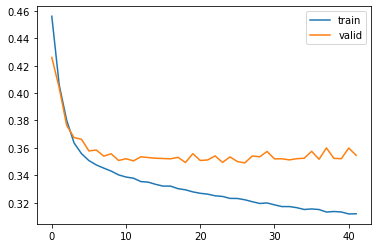

In [121]:
# Capturing learning history per epoch
hist5  = pd.DataFrame(his_mod5.history)
hist5['epoch'] = his_mod5.epoch

# Plotting accuracy at different epochs
plt.plot(hist5['loss'])
plt.plot(hist5['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#### plot confusion matrix after identifying optimal threshold

#### Evaluation

In [122]:
score5 = model5.evaluate(X_test,y_test)


63/63 [==============================] - 1s 2ms/step - loss: 0.3598 - accuracy: 0.8540 - recall: 0.4840


* It seems that model has good accuracy of .851 but we have to see for further improvements and tunning as this is imbalance dataset.

In [123]:
print(score5)

[0.35983142256736755, 0.8539999723434448, 0.48402947187423706]


In [124]:
y_pred5=model5.predict(X_test)

In [125]:
y_pred5_train=model5.predict(X_train)

#### roc curve

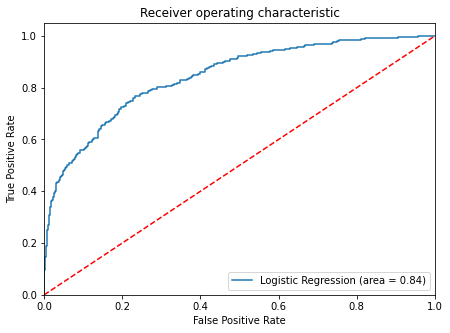

In [126]:
roc_curve_plot(model5,X_test,y_test)

In [127]:
#get optimal threshold
opt_Threshold5= get_optimal_threshold(y_test,y_pred5)

0.19519705


In [128]:
create_classLabels(y_pred5,y_test,opt_Threshold5)

In [129]:

create_classLabels(y_pred5_train,y_train,opt_Threshold5)

In [130]:
pd.DataFrame(y_pred5).value_counts()

0.0    1320
1.0     680
dtype: int64

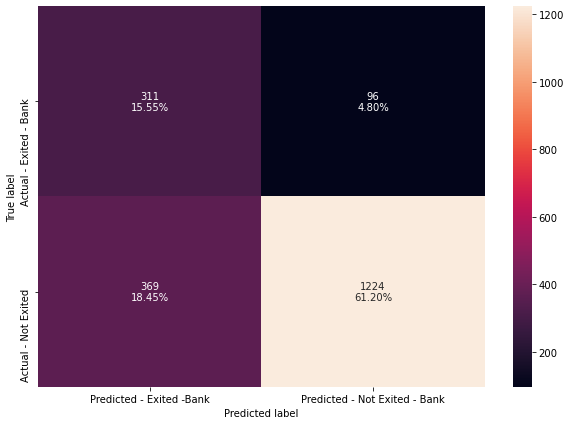

In [131]:
make_confusion_matrix(y_pred5,y_test)

* model predict 79.35% TP and TN and only 20.65% FP and FN.

In [132]:



recall_5 = recall_score(y_test,y_pred5)
print(f'Recall score for model5 - {recall_5}')

f1score_5 = f1_score(y_test,y_pred5)
print(f'f1 score for model5 - {f1score_5}')

acc_score_5 = accuracy_score(y_test,y_pred5)
print(f'accuracy score for model5 - {acc_score_5}')

recall_train_5 = recall_score(y_train,y_pred5_train)
print(f'Recall score for train data - model5 - {recall_train_5}')

f1score_train_5 = f1_score(y_train,y_pred5_train)
print(f'f1 score for train data - model5 - {f1score_train_5}')

acc_score_train_5 = accuracy_score(y_train,y_pred5_train)
print(f'accuracy score for train data - model5 - {acc_score_train_5}')

Recall score for model5 - 0.7641277641277642
f1 score for model5 - 0.5722171113155474
accuracy score for model5 - 0.7675
Recall score for train data - model5 - 0.8104294478527607
f1 score for train data - model5 - 0.6070772058823529
accuracy score for train data - model5 - 0.78625


#### Model- 6

Adding dropout **layer**

In [133]:
#initializing ANN
model6=Sequential()
input_layer=Dense(16,activation='relu',input_shape=X_train.shape )
model6.add(input_layer)
model6.add(Dropout(0.1))# defining the batchnorm

model6.add(Dense(32,activation='relu'))
model6.add(Dense(64,activation='relu'))

model6.add(Dense(1,activation='sigmoid'))

## Model compilation
##creating optimizer with default learning rate
optimizer = tf.keras.optimizers.RMSprop(0.001)
model6.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy','Recall'])

In [134]:
#Lets  print summary of model
model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 8000, 16)          192       
_________________________________________________________________
dropout (Dropout)            (None, 8000, 16)          0         
_________________________________________________________________
dense_18 (Dense)             (None, 8000, 32)          544       
_________________________________________________________________
dense_19 (Dense)             (None, 8000, 64)          2112      
_________________________________________________________________
dense_20 (Dense)             (None, 8000, 1)           65        
Total params: 2,913
Trainable params: 2,913
Non-trainable params: 0
_________________________________________________________________


#### Training the model

In [135]:
history6=model6.fit(X_train,y_train,batch_size=15,epochs=100,validation_split=0.2)

Epoch 1/100
427/427 [==============================] - 4s 4ms/step - loss: 0.4523 - accuracy: 0.8041 - recall: 0.0965 - val_loss: 0.4066 - val_accuracy: 0.8200 - val_recall: 0.2448
Epoch 2/100
427/427 [==============================] - 1s 2ms/step - loss: 0.3951 - accuracy: 0.8291 - recall: 0.3290 - val_loss: 0.3742 - val_accuracy: 0.8394 - val_recall: 0.3821
Epoch 3/100
427/427 [==============================] - 1s 2ms/step - loss: 0.3766 - accuracy: 0.8397 - recall: 0.3900 - val_loss: 0.3687 - val_accuracy: 0.8425 - val_recall: 0.3194
Epoch 4/100
427/427 [==============================] - 1s 2ms/step - loss: 0.3725 - accuracy: 0.8413 - recall: 0.3946 - val_loss: 0.3645 - val_accuracy: 0.8462 - val_recall: 0.3582
Epoch 5/100
427/427 [==============================] - 1s 2ms/step - loss: 0.3690 - accuracy: 0.8423 - recall: 0.3931 - val_loss: 0.3628 - val_accuracy: 0.8544 - val_recall: 0.4627
Epoch 6/100
427/427 [==============================] - 1s 2ms/step - loss: 0.3650 - accuracy: 0

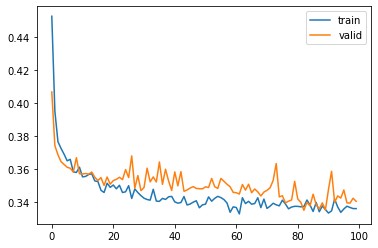

In [136]:
# Capturing learning history per epoch
hist6  = pd.DataFrame(history6.history)
hist6['epoch'] = history6.epoch

# Plotting accuracy at different epochs
plt.plot(hist6['loss'])
plt.plot(hist6['val_loss'])
plt.legend(("train" , "valid") , loc =0)

In [137]:
history6.history

{'loss': [0.45233744382858276,
  0.3950776159763336,
  0.3765948414802551,
  0.3725392818450928,
  0.3690173029899597,
  0.36504825949668884,
  0.3659333884716034,
  0.35843411087989807,
  0.35799485445022583,
  0.36118483543395996,
  0.35534465312957764,
  0.3556206226348877,
  0.35677897930145264,
  0.357197642326355,
  0.35288897156715393,
  0.3525206446647644,
  0.3472490608692169,
  0.3459288775920868,
  0.3515142500400543,
  0.3490183353424072,
  0.35042691230773926,
  0.3481384515762329,
  0.3502822816371918,
  0.3458942174911499,
  0.3463297188282013,
  0.3500242531299591,
  0.34230655431747437,
  0.348052978515625,
  0.3458646833896637,
  0.34402164816856384,
  0.34246140718460083,
  0.341678261756897,
  0.34128648042678833,
  0.3478615880012512,
  0.34073176980018616,
  0.3405596613883972,
  0.3423471450805664,
  0.3417279124259949,
  0.3433148264884949,
  0.3435588479042053,
  0.3402498662471771,
  0.33946046233177185,
  0.33986252546310425,
  0.3434927463531494,
  0.3383794

#### plot confusion matrix after identifying optimal threshold

#### Evaluation

In [138]:
score6 = model6.evaluate(X_test,y_test)


63/63 [==============================] - 0s 1ms/step - loss: 0.3541 - accuracy: 0.8610 - recall: 0.4201


* It seems that model has good accuracy of .851 but we have to see for further improvements and tunning as this is imbalance dataset.

In [139]:
print(score6)

[0.3541327118873596, 0.8610000014305115, 0.4201474189758301]


In [140]:
y_pred6=model6.predict(X_test)

In [141]:
y_pred6_train=model6.predict(X_train)

#### roc curve

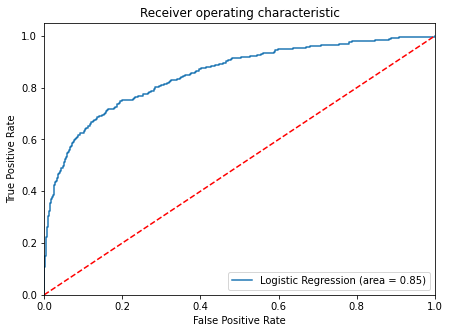

In [142]:
roc_curve_plot(model6,X_test,y_test)

In [143]:
#get optimal threshold
opt_Threshold6= get_optimal_threshold(y_test,y_pred6)

0.22678435


In [144]:
create_classLabels(y_pred6,y_test,opt_Threshold6)

In [145]:

create_classLabels(y_pred6_train,y_train,opt_Threshold6)

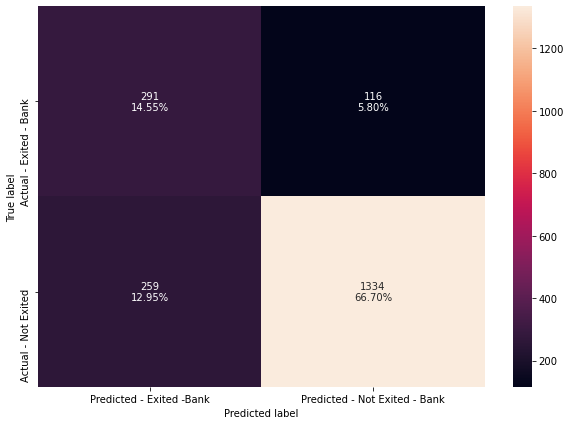

In [146]:
make_confusion_matrix(y_pred6,y_test)

* model predict 79.1% TP and TN and only 20.9% FP and FN.

In [147]:



recall_6 = recall_score(y_test,y_pred6)
print(f'Recall score for model1 - {recall_6}')

f1score_6 = f1_score(y_test,y_pred6)
print(f'f1 score for model1 - {f1score_6}')

acc_score_6 = accuracy_score(y_test,y_pred6)
print(f'accuracy score for model1 - {acc_score_6}')

recall_train_6 = recall_score(y_train,y_pred6_train)
print(f'Recall score for train data - model6 - {recall_train_6}')

f1score_train_6 = f1_score(y_train,y_pred6_train)
print(f'f1 score for train data - model6 - {f1score_train_6}')

acc_score_train_6 = accuracy_score(y_train,y_pred6_train)
print(f'accuracy score for train data - model6 - {acc_score_train_6}')

Recall score for model1 - 0.714987714987715
f1 score for model1 - 0.6081504702194358
accuracy score for model1 - 0.8125
Recall score for train data - model6 - 0.7282208588957055
f1 score for train data - model6 - 0.6383436407636461
accuracy score for train data - model6 - 0.831875


## 7.  Model Evaluation : Comparing all the models based on the metrics 

In [148]:
# defining list of models
models = [model,model2,model3,model4,model5,model6]
# defining empty lists to add train and test results

acc_train = [acc_score_train_1, acc_score_train_2,acc_score_train_3,acc_score_train_4,acc_score_train_5,acc_score_train_6]
acc_test = [acc_score_test_1,acc_score_test_2,acc_score_3,acc_score_4,acc_score_5,acc_score_6 ]
recall_train = [recall_train_1,recall_train_2,recall_train_3,recall_train_4,recall_train_5,recall_train_6]
recall_test = [recall_test_1,recall_test_2,recall_3,recall_4,recall_5,recall_6]
f1_score_train=[f1score_train_1,f1score_train_2,f1score_train_3,f1score_train_4,f1score_train_5,f1score_train_6]
f1_score_test=[f1score_test_1,f1score_test_2,f1score_3,f1score_4,f1score_5,f1score_6 ]


In [149]:
comparison_frame = pd.DataFrame({'Model':['ANN-Adam-hidden1','ANN-Adam-0.01-hidden1','ANN-RMSPROP-.001-hidden1',
                                         'ANN-RMSPROP-.001-hidden2','ANN-RMSPROP-earlystopping','ANN-RMSPROP-dropout'], 
                                          'Train_Accuracy': acc_train,
                                          'Test_Accuracy': acc_test,
                                          'Train_Recall': recall_train,
                                          'Test_Recall': recall_test,
                                          'Train_f1score': f1_score_train,
                                          'Test_f1score': f1_score_test}) 
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_f1score,Test_f1score
0,ANN-Adam-hidden1,0.856875,0.8465,0.607362,0.557740,0.633600,0.596583
1,ANN-Adam-0.01-hidden1,0.811875,0.7845,0.770552,0.717445,0.625342,0.575369
2,ANN-RMSPROP-.001-hidden1,0.766000,0.7485,0.817791,0.783784,0.587483,0.559159
3,ANN-RMSPROP-.001-hidden2,0.814375,0.7905,0.771166,0.722359,0.628657,0.583913
4,ANN-RMSPROP-earlystopping,0.786250,0.7675,0.810429,0.764128,0.607077,0.572217
5,ANN-RMSPROP-dropout,0.831875,0.8125,0.728221,0.714988,0.638344,0.608150


* The best model is ANN with RMSProp optimizer and 0.001 learning and 2 hidden layers. it has best recall score (.786) and accuracy and f1score is also good. so we can consider it as good model.

## 8. Conclusion:



 As you can see here the Recall is increased but the f1 score is low.  There is still  lot of scope of  improvements  as follows:

1) Threshold can be tuned to get the optimal value 

2) Resampling techniques can be applied to balanced the data and then train the model 



We can select the Model-4 as our final model based on the above analysis 